# Centróides Sul  

### *Dados padronizados

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/centroides_sul.ipynb`


## Bibliotecas

In [1]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

Requirement already up-to-date: pyshp in /home/walef/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: descartes in /home/walef/anaconda3/lib/python3.7/site-packages (1.1.0)


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [2]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [3]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [4]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [5]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [6]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [7]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [8]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [9]:
dados.reset_index(level = 0, inplace = True)

In [10]:
dados.shape

(2293, 9)

In [11]:
dados = dados.merge(cod, on='mun')

In [12]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [13]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [14]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [15]:
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [16]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [17]:
dados_br = cod_dados.merge(seguro, how='left')

In [18]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

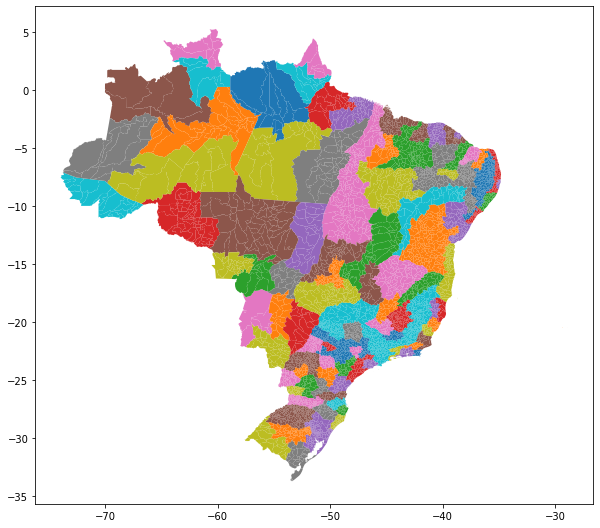

In [19]:
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Sul

In [20]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

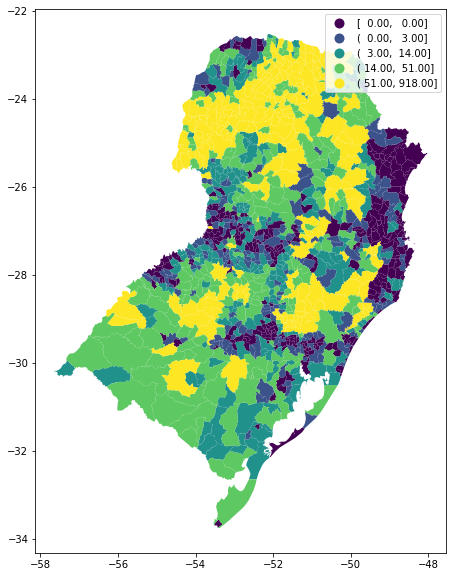

In [21]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd'

## Centroides Sul

In [22]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

In [30]:
#wq = Queen.from_dataframe(dados_sul)
#wq.transform = 'r'
#ax = dados_sul.plot(edgecolor='k', facecolor='w', figsize=(10, 10))
#wq.plot(dados_sul, ax=ax, 
#        edge_kws=dict(color='r', linestyle=':', linewidth=1),
#        node_kws=dict(marker=''))
#ax.set_axis_off()

In [24]:
dados_sul.geometry.centroid.x
dados_sul['x_centroid'] = dados_sul.geometry.centroid.x
dados_sul['y_centroid'] = dados_sul.geometry.centroid.y

/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
dados_centroids = dados_sul
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'rm', 'Unnamed: 0'] # , 'geometry'
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides - Sul

In [32]:
# subselecionar variáveis
X = scale(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
# mudar o tipo dos dados
X = np.asarray(X, dtype=float)
n = X.shape[0]
p = X.shape[1]
# vetor de médias
Xb = np.mean(X, axis=0)
# matriz de covariâncias
S = np.cov(X.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [33]:
Z = linkage(X, method='ward')

In [34]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

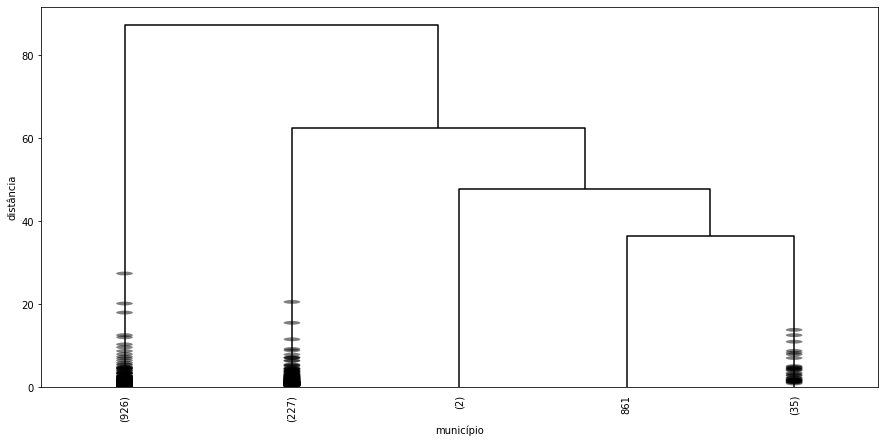

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [36]:
Z = linkage(X, method='ward')

In [37]:
## definir a distância de corte baseando no dendrograma
max_d = 30
grupos = cut_tree(Z, height=max_d)

### Métricas

In [39]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

519.56 0.77 0.28


In [40]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [41]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

2    736
0    227
1    190
3     35
4      2
5      1
Name: grupo, dtype: int64

In [42]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,,,
0,97.193833,1.379021e+07,1.070125e+06,4.666398e+05,1.129211e+06,26405.805330,1553.802775,29.872247,-51.866923,-24.935246
1,3.673684,5.497977e+05,2.766764e+04,1.105357e+04,6.317988e+03,409.738526,47.584842,0.273684,-49.366685,-27.451969
2,11.336957,2.093203e+06,1.402019e+05,5.957672e+04,7.143523e+04,2474.886454,258.389878,1.729620,-52.558106,-27.599357
3,330.857143,4.065754e+07,3.244064e+06,1.418520e+06,6.092920e+06,53168.010857,2569.152000,143.342857,-52.001272,-25.441648
4,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,-50.468961,-28.334531
5,918.000000,8.732306e+07,6.465593e+06,2.909516e+06,3.700306e+07,72396.460000,2341.400000,771.000000,-51.221204,-29.031462


In [43]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,,,
0,85.0,1.134663e+07,9.275047e+05,396027.77,842603.90,26297.00,1558.23,24.0,-51.770618,-24.206093
1,0.0,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.0,-49.318651,-27.303731
2,4.0,4.805166e+05,3.630332e+04,15664.27,0.00,0.00,152.08,0.0,-52.602405,-27.702076
3,310.0,3.704052e+07,2.968125e+06,1326166.33,4906366.66,54119.00,2656.58,114.0,-51.651783,-24.361220
4,487.0,1.557418e+08,2.156674e+07,9364997.51,2660478.72,12995.41,2057.35,57.0,-50.468961,-28.334531
5,918.0,8.732306e+07,6.465593e+06,2909515.95,37003064.14,72396.46,2341.40,771.0,-51.221204,-29.031462


### As observações de cada grupo

In [44]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides Sul

In [45]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

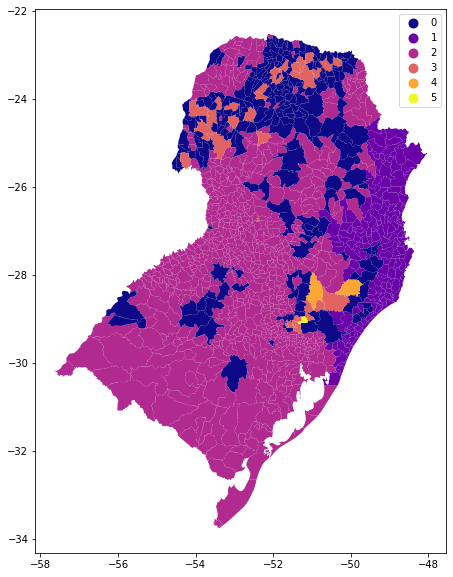

In [46]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'

## K-Médias - Sul

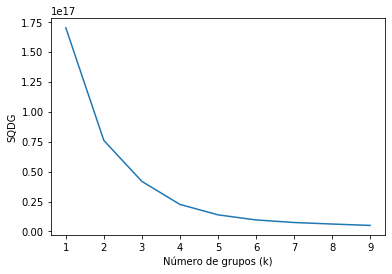

In [47]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [48]:
k = 4

In [49]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [50]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [51]:
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

578.83 0.85 0.5


In [52]:
# contagens
dados_centroids.grupo.value_counts()

0    957
2    202
1     30
3      2
Name: grupo, dtype: int64

In [53]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,12.177638,2.081267e+06,1.386560e+05,5.875223e+04,5.989109e+04,2056.982936,229.400878,1.704284,-51.834288,-27.546985,5.137931
1,370.966667,4.530640e+07,3.581921e+06,1.566104e+06,7.699012e+06,54169.632000,2466.542667,175.400000,-52.011060,-25.936046,2.933333
2,103.069307,1.452876e+07,1.144654e+06,5.011118e+05,1.346915e+06,30857.127574,1735.931188,34.658416,-52.186870,-24.595270,4.410891
3,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,-50.468961,-28.334531,5.000000


In [54]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,3.0,3.512332e+05,2.575345e+04,10728.190,0.000,0.00,106.050,0.0,-52.040032,-27.590677,6
1,326.5,4.314106e+07,3.485168e+06,1530744.175,5668899.830,55358.00,2503.540,125.0,-51.602048,-24.791050,2
2,89.0,1.159572e+07,9.695378e+05,423888.905,1061090.055,29644.00,1685.555,27.5,-51.970404,-24.034659,4
3,487.0,1.557418e+08,2.156674e+07,9364997.510,2660478.720,12995.41,2057.350,57.0,-50.468961,-28.334531,5


In [55]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides K-médias Sul

In [56]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

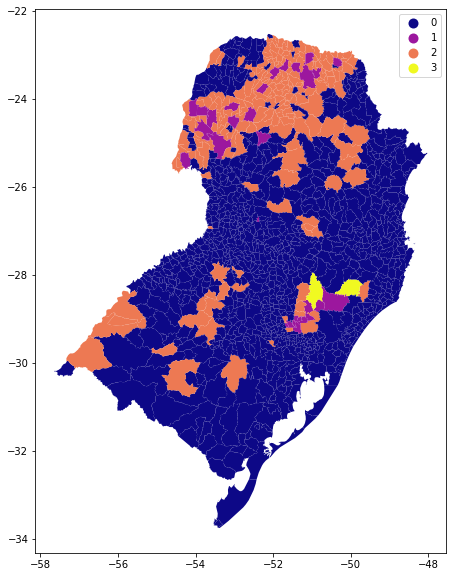

In [57]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'